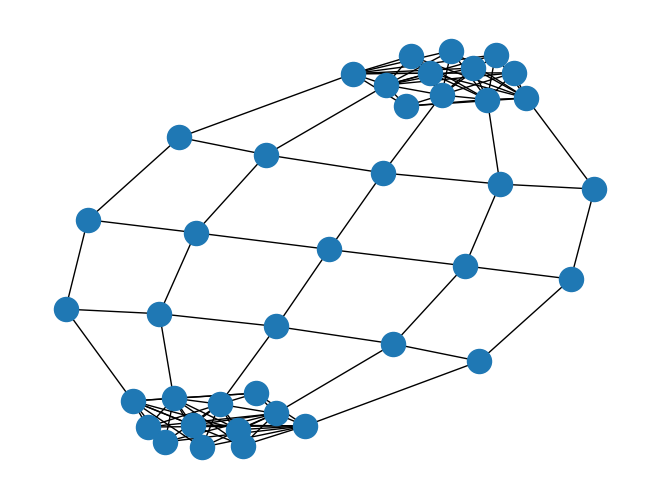

In [11]:
from turtle import up
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
from utils import *
from model import UpdateRule


height = 1
width = 5
hidden_dim = 32

n_inputs = 7
n_outputs = 7


update_rule = UpdateRule(
    n_inputs, 
    n_outputs,
    hidden_dim,
    64
)
update_rule.build_graph(
    height,
    width
)


update_rule.draw()

In [12]:
from datasets import *
import copy
import numpy as np
np.set_printoptions(precision=1, suppress=True)



# dataset_loader = DataLoader(TranslateDataset(), batch_size=1, shuffle=True)

meta_set = MetaDataset()

optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.005)

best_loss = 10000
best_model = None

n_steps = 2
batch_size = 50
for epoch in range(10000):
    loss = 0
    for _ in range(batch_size):
        for set_idx in meta_set.iterate():
            update_rule.reset() 
            x = update_rule.initial_state(height, width)
        
            for idx, (problem_data_x, problem_data_y) in enumerate(meta_set.get_set(set_idx)):
                output_data = None#torch.zeros_like(problem_data_y.float())
                # if idx == meta_set.get_set_size() - 1:
                #     output_data = None#problem_data_y.float()

                for i in range(n_steps):
                    # problem_data_x = torch.zeros_like(problem_data_x)
                    x = update_rule(x, problem_data_x.float(), output_data)
                    
                break
                
            network_output = update_rule.get_output(x)
            # loss = F.mse_loss(problem_data_y.float().squeeze(0), network_output)
            loss += F.mse_loss(problem_data_y.float().squeeze(0), network_output)
            # loss.backward()  
    if loss < best_loss:
        best_model = copy.deepcopy(update_rule)
        best_loss = loss
     
    loss /= batch_size   
    loss.backward()
    optimizer.step()  
    optimizer.zero_grad()  
        
    print(f"""\r 
          Epoch {epoch * batch_size} |
          Loss {loss:.6} |
          Network in: {problem_data_x.numpy()} |
          Network out: {network_output.detach().numpy()} |
          Correct:  {problem_data_y.numpy()}
        """.replace("\n", " ").replace("         ", ""), end="")
    # print(f"\r Epoch {epoch * batch_size} | Loss {loss} | Height {height}", end="")
    
    if epoch % (200 // batch_size) == 0:
        print()


   Epoch 0 |  Loss 0.122449 |  Network in: [[0 0 1 0 0 0 0]] |  Network out: [0.1 0.1 0.1 0.1 0.1 0.1 0.1] |  Correct:  [[0 0 0 1 0 0 0]]
   Epoch 200 |  Loss 0.122448 |  Network in: [[1 0 0 0 0 0 0]] |  Network out: [0.1 0.1 0.1 0.1 0.1 0.1 0.1] |  Correct:  [[0 1 0 0 0 0 0]]
   Epoch 400 |  Loss 0.122449 |  Network in: [[0 1 0 0 0 0 0]] |  Network out: [0.1 0.1 0.1 0.1 0.1 0.1 0.1] |  Correct:  [[0 0 1 0 0 0 0]]
   Epoch 600 |  Loss 0.122447 |  Network in: [[0 0 0 0 0 1 0]] |  Network out: [0.1 0.1 0.1 0.1 0.1 0.1 0.1] |  Correct:  [[0 0 0 0 0 0 1]]
   Epoch 800 |  Loss 0.122447 |  Network in: [[0 0 0 0 1 0 0]] |  Network out: [0.1 0.1 0.1 0.1 0.1 0.1 0.1] |  Correct:  [[0 0 0 0 0 1 0]]
   Epoch 1000 |  Loss 0.122447 |  Network in: [[0 0 0 0 0 0 1]] |  Network out: [0.1 0.1 0.1 0.1 0.1 0.1 0.1] |  Correct:  [[1 0 0 0 0 0 0]]
   Epoch 1200 |  Loss 0.122439 |  Network in: [[0 1 0 0 0 0 0]] |  Network out: [0.1 0.1 0.1 0.1 0.1 0.1 0.1] |  Correct:  [[0 0 1 0 0 0 0]]
   Epoch 1400 |  Los

KeyboardInterrupt: 

In [ ]:
import numpy as np
np.set_printoptions(precision=3)

run_rule(torch.tensor([[0,0,0,1]]), update_rule)

In [ ]:
#save update_rule model dont use state dict
torch.save(update_rule, "update_rule.pt")


In [ ]:

def run_rule_meta(update_rule, training, test, n_steps):
    x = update_rule.initial_state(height, width)
    for (problem_x, problem_y) in training:
        print(problem_x)
        for _ in range(n_steps):
            x = update_rule(x, problem_x.float(), problem_y.float())
            
            
    for _ in range(n_steps):
        x = update_rule(x, test.float())
        
    network_output = update_rule.get_output(x).detach()
    return network_output
    

In [ ]:
# run_rule_meta(update_rule, torch.tensor([
#     ([1,0,0,0], [0,1,0,0]),
#     ([0,1,0,0], [0,0,1,0]),
#     ([0,0,1,0], [0,0,0,1]),
#     ]), torch.tensor([0,1,0,0]), 8)

# run_rule_meta(best_model, torch.tensor([
#     ([1,0,0,0,0,0,0], [0,1,0,0,0,0,0]),
#     ([0,1,0,0,0,0,0], [0,0,1,0,0,0,0]),
#     # ([0,0,1,0,0,0,0], [0,1,0,0,0,0,0]),
#     ([0,0,0,1,0,0,0], [0,0,0,0,1,0,0]),
#     ([0,0,0,0,1,0,0], [0,0,0,0,0,1,0]),
#     ([0,0,0,0,0,1,0], [0,0,0,0,0,0,1]),
#     ([0,0,0,0,0,0,1], [1,0,0,0,0,0,0]),
#     ]), torch.tensor([0,0,1,0,0,0,0]), n_steps)

run_rule_meta(best_model, torch.tensor([
    ([1,0,0,0,0,0,0], [0,0,0,0,0,0,1]),
    ([0,1,0,0,0,0,0], [1,0,0,0,0,0,0]),
    # ([0,0,1,0,0,0,0], [0,1,0,0,0,0,0]),
    ([0,0,0,1,0,0,0], [0,0,1,0,0,0,0]),
    ([0,0,0,0,1,0,0], [0,0,0,1,0,0,0]),
    ([0,0,0,0,0,1,0], [0,0,0,0,1,0,0]),
    ([0,0,0,0,0,0,1], [0,0,0,0,0,1,0]),
    ]), torch.tensor([0,0,1,0,0,0,0]), n_steps)

tensor([1, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1])


tensor([0.1322, 0.1611, 0.0821, 0.4719, 0.0192, 0.1007, 0.0329])

In [ ]:
best_loss

tensor(0.0010, grad_fn=<MseLossBackward0>)

In [ ]:
n = 7
arr = torch.arange(n)

In [ ]:
data =  DataLoader(TranslateDataset() , batch_size=1, shuffle=True)

for sample in data:
    print(sample)

In [ ]:
from torch_geometric.nn import aggr
